# LoC thresholding notebook

This notebook loads a set of Z-tracks taken across an image volume from the lung-on-a-chip project and thresholds positive/negative expression of set markers based on a manual and unbiased assessment of the underlying images:

1. Load z-tracks, segmentation and images.
2. Initiate a Napari viewer with key bindings to annotate positive/negative expressing cells
3. Assess results
4. Quantify based on manually chosen thresholds

In [143]:
import btrack # import tracking software
import napari # image viewer
from skimage import io # image loader and viewer
import os # for filename manipulations
import glob # for more fn operations 
import pandas as pd # module for data org 
import matplotlib.pyplot as plt # module for plotting
import seaborn as sns # module for plotting
import numpy as np # for math operations
sns.set(font='Nimbus Sans', style = 'white') # my favourite formatting :)
sns.set_palette('PiYG') # my favourite colours :D 

## 1. Load images and labels

In [212]:
image_fn = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/image analysis_Nathan/Job_Mtb area/run1_23-01-001_23-01-005/2h pi/20230707_40X_23-01-001A3_Multichannel Z-Stack_20230707_1319.tif'
image = io.imread(image_fn) # load image

In [226]:
# set filename
labels_fn = '/home/dayn/data/homuncu_loc_temp/run1_23-01-001_23-01-005/2h pi/20230707_40X_23-01-001A3_Multichannel Z-Stack_20230707_1319_z_tracks_masks.h5'
# load labels (tracks and segmentation)
with btrack.io.HDF5FileHandler(labels_fn, 
                                   'r', 
                                       obj_type='obj_type_1'
                                   ) as reader:
        tracks = [t for t in reader.tracks if np.mean(t.properties['area']) > 1000]
        segmentation = reader.segmentation
napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim = 2)

[INFO][2023/07/28 01:35:31 pm] Opening HDF file: /home/dayn/data/homuncu_loc_temp/run1_23-01-001_23-01-005/2h pi/20230707_40X_23-01-001A3_Multichannel Z-Stack_20230707_1319_z_tracks_masks.h5...
28-Jul-23 13:35:31 - btrack.io.hdf - INFO     - Opening HDF file: /home/dayn/data/homuncu_loc_temp/run1_23-01-001_23-01-005/2h pi/20230707_40X_23-01-001A3_Multichannel Z-Stack_20230707_1319_z_tracks_masks.h5...
[INFO][2023/07/28 01:35:31 pm] Loading tracks/obj_type_1
28-Jul-23 13:35:31 - btrack.io.hdf - INFO     - Loading tracks/obj_type_1
[INFO][2023/07/28 01:35:31 pm] Loading LBEP/obj_type_1
28-Jul-23 13:35:31 - btrack.io.hdf - INFO     - Loading LBEP/obj_type_1
[INFO][2023/07/28 01:35:31 pm] Loading objects/obj_type_1 (60184, 5) (60184 filtered: None)
28-Jul-23 13:35:31 - btrack.io.hdf - INFO     - Loading objects/obj_type_1 (60184, 5) (60184 filtered: None)
[INFO][2023/07/28 01:35:45 pm] Loading segmentation (317, 2304, 2304)
28-Jul-23 13:35:45 - btrack.io.hdf - INFO     - Loading segmentati

## 2. Initiate a napari session with key bindings

In [232]:
output_dir = os.path.dirname(labels_fn)

In [257]:
image_id = re.search(r'\d+(?=_z_tracks)', os.path.basename(labels_fn)).group()

In [233]:
output_dir

'/home/dayn/data/homuncu_loc_temp/run1_23-01-001_23-01-005/2h pi'

## Thresholding instructions

In [258]:
viewer = napari.Viewer()

viewer.add_image(image, channel_axis=-1)
track_layer = viewer.add_tracks(napari_tracks, tail_length=0, visible = False)
labels = viewer.add_labels(segmentation)
labels.contour = 1 # this makes all the masks into outlines but might slow your computer down A LOT (comment out line if so) 
global image_id 
image_id = re.search(r'\d+(?=_z_tracks)', os.path.basename(labels_fn)).group()

@viewer.bind_key('t')
def ch1_extract_positive_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = track_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity'][:,1][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, f"{image_id}_ch1_positive_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")
@viewer.bind_key('b')
def ch1_extract_negative_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = track_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity'][:,1][cell_index]
    with open(os.path.join(output_dir, f"{image_id}_ch1_negative_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")

@viewer.bind_key('y')
def ch2_extract_positive_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = track_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity'][:,2][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, f"{image_id}_ch2_positive_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")
@viewer.bind_key('n')
def ch2_extract_negative_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = track_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity'][:,2][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, f"{image_id}_ch2_negative_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")

@viewer.bind_key('u')
def ch3_extract_positive_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = track_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity'][:,3][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, f"{image_id}_ch3_positive_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")
@viewer.bind_key('m')
def ch3_extract_negative_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = track_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity'][:,3][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, f"{image_id}_ch3_negative_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered i

## Load results of unbiased thresholding

Loading many single-cell measurements of positive and negative cells to decide where the threshold between them is (simply by plotting and deciding at the moment).

In [298]:
df = dict()
channels = [3] #1 , 2
for channel in channels:
    for fn in glob.glob(os.path.join(output_dir, f'{image_id}_ch{channel}*.csv')):
        if 'positive' in fn:
            positive_df = pd.read_csv(fn, names=["cell ID", "z slice", "Positive Mean Pixel Intensity"]).replace(r'\(|\)', '', regex=True)
            positive_df.apply(pd.to_numeric, errors='coerce')
        if 'negative' in fn:
            negative_df = pd.read_csv(fn, names=["cell ID", "z slice", "Negative Mean Pixel Intensity"]).replace(r'\(|\)', '', regex=True)
            negative_df.apply(pd.to_numeric, errors='coerce')
    df[channel] = pd.concat((negative_df, positive_df), axis = 1).drop(columns = ['cell ID', 'z slice']).apply(pd.to_numeric, errors='coerce')

Text(0.5, 1.0, 'Positive/negative pixel distribution across channel 3')

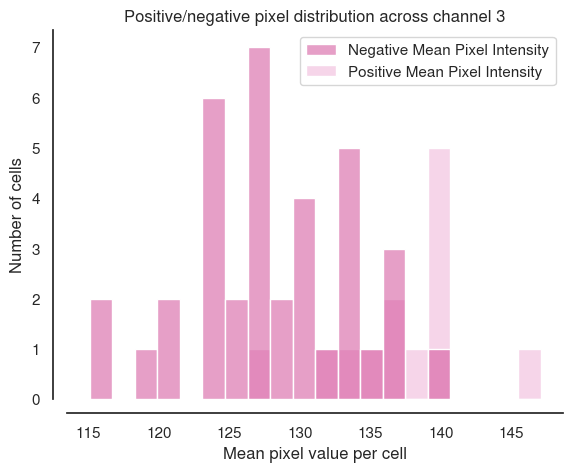

In [303]:
channel = 3
sns.histplot(data = df[channel], bins = 20)
sns.despine(offset = 10)
plt.xlabel('Mean pixel value per cell')
plt.ylabel('Number of cells')
plt.title(f'Positive/negative pixel distribution across channel {channel}')

## Decide threshold label and replot

In [304]:
threshold = 230

Text(0.5, 1.0, 'Positive/negative pixel distribution across channel:1')

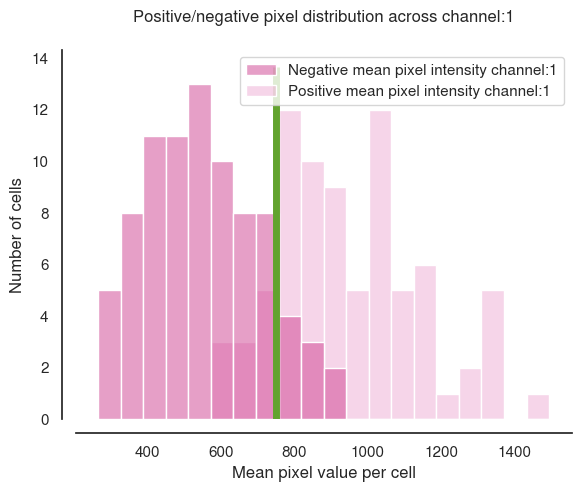

In [177]:
channel = 1
ax = sns.histplot(data=df[channel], bins=20)
sns.despine(offset=10)
plt.vlines(x=threshold,
           ymax=ax.get_ylim()[-1],
           ymin=ax.get_ylim()[0],
           color=sns.color_palette('PiYG')[-1],  # my favorite colors :D
           linewidth=5)
# plt.text(x=threshold, y=ax.get_ylim()[-1], s='Threshold')
plt.xlabel('Mean pixel value per cell')
plt.ylabel('Number of cells')
plt.title(f'Positive/negative pixel distribution across channel {channel}', pad =20)
# plt.legend(['Threshold'], loc='lower right')

## Quantify

Quantification of number of different cell types according to manually set thresholds

#### Filter tracks first

This is to avoid erroneous single-cell measurements appearing in final quantifications. Previously filtering any track lengths below 3 consecutive z-slices has worked well. This may need revision for bilayer instance.

In [162]:
filtered_tracks = [t for t in tracks if len(t) >= 3]

In [305]:
tracks[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,axis_minor_length,mean_intensity,area,axis_major_length,eccentricity,orientation
0,1115,21,1805.787720,2219.309814,0.0,1115,1115,5,0,False,22.695286,"(4,) array",584.0,33.178761,0.729453,-1.508589
1,1115,22,1809.390991,2221.034180,0.0,1115,1115,5,0,False,38.795921,"(4,) array",1698.0,57.042225,0.733095,1.424329
2,1115,23,1804.944824,2219.657959,0.0,1115,1115,5,0,False,33.961529,"(4,) array",1269.0,48.571308,0.714917,-1.493403
3,1115,24,1806.639893,2220.802734,0.0,1115,1115,5,0,False,24.358036,"(4,) array",897.0,51.488976,0.881023,1.385273
4,1115,25,1803.121826,2218.988770,0.0,1115,1115,5,0,False,25.205412,"(4,) array",796.0,41.000370,0.788714,1.256958
5,1115,26,1804.885742,2217.802246,0.0,1115,1115,5,0,False,35.046753,"(4,) array",1295.0,47.928257,0.682127,1.379854
6,1115,27,1806.106323,2216.623779,0.0,1115,1115,5,0,False,31.901186,"(4,) array",1241.0,50.950039,0.779721,1.446250
7,1115,28,1806.600098,2216.389404,0.0,1115,1115,5,0,False,34.844349,"(4,) array",1433.0,54.261333,0.766572,1.561883
8,1115,29,1805.393433,2216.273682,0.0,1115,1115,5,0,False,33.341610,"(4,) array",1352.0,53.984863,0.786484,1.383469
9,1115,30,1805.167114,2215.170898,0.0,1115,1115,5,0,False,33.295429,"(4,) array",1352.0,53.633675,0.783974,1.359977


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered i

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (


In [310]:
tracks[0].properties['mean_intensity'][:,3]

array([118.287674, 118.63369 , 119.41371 , 120.29431 , 122.71859 ,
       122.75753 , 123.524574, 125.41382 , 127.48151 , 129.34541 ,
       130.69757 , 133.19757 , 135.54388 , 137.09444 , 139.21832 ,
       140.93037 , 141.31648 , 141.55275 , 142.43636 , 142.86761 ,
       143.90953 , 144.02682 , 144.73134 , 145.61543 , 145.79288 ,
       145.09343 , 145.15309 , 143.2115  , 143.77655 , 141.72705 ,
       140.94768 ], dtype=float32)

#### Print number of positive and negative cells

In [196]:
channel = 1
n_positive = len([t for t in filtered_tracks if np.max(t.properties['mean_intensity'][:,channel]) >= threshold])
n_negative = len([t for t in filtered_tracks if np.max(t.properties['mean_intensity'][:,channel]) < threshold])
print(f'Number of channel {channel} positive cells: {n_positive}')
print(f'Number of channel {channel} negative cells: {n_negative}')
percentage = n_positive / (n_positive+n_negative) *100
print(f'Percentage of positive cells: {percentage:.2f}%')

Number of channel 1 positive cells: 3274
Number of channel 1 negative cells: 2465
Percentage of positive cells: 57.05%


#### Plot the number of cells either side of the threshold

Text(0.5, 1.0, 'Distribution of single-cell maximum pixel value for channel 1')

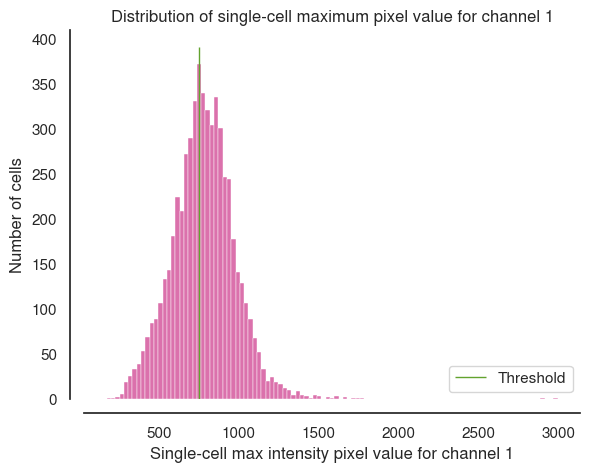

In [199]:
sc_intensities = [np.max(t.properties['mean_intensity'][:,channel]) for t in filtered_tracks]
ax = sns.histplot(sc_intensities)
plt.vlines(x=threshold,
           ymax=ax.get_ylim()[-1],
           ymin=ax.get_ylim()[0],
           color=sns.color_palette('PiYG')[-1],  # my favorite colors :D
           linewidth=1)
sns.despine(offset = 10)
plt.xlabel(f'Single-cell max intensity pixel value for channel {channel}')
plt.ylabel('Number of cells')
plt.legend(['Threshold'], loc='lower right')
plt.title(f'Distribution of single-cell maximum pixel value for channel {channel}')

# Save out as df/excel

In [ ]:
### define parameters to plot in table
cols = ['Cell ID', f'Max. int. {channels(0).name}', f'Max. int. {channels(1).name}', f'Max. int. {channels(2).name}', f'Max. int. {channels(3).name}', 'Average X', 'Average Y']
### extract some intial measurements
df = pd.DataFrame([(track.ID, np.nanmax(track['mean_intensity-0']),np.nanmax(track['mean_intensity-1']),np.nanmax(track['mean_intensity-2']),np.nanmax(track['mean_intensity-3']), np.mean(track.x), np.mean(track.y)) for track in filtered_tracks], columns= cols)